In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
%cd ..

/Users/massil/repos/newsvendor_tester


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


from preprocessing_script import NB_PRODUCTS
from environment import *
from algorithms.ddm import DDM_algorithm
from algorithms.rcosd_adaptive_volume_constrained import RCOSD_Adaptive_Volume_Constrained_algorithm
from algorithms.rcosd_variant_volume_constrained import RCOSD_Variant_Volume_Constrained_algorithm
from algorithms.rcosd_generic import RCOSD_generic_algorithm
from algorithms.cosd_variant2_volume_constrained import COSD_Variant2_Volume_Constrained_algorithm
from algorithms.osd_dynamic_projection_volume_constrained import OSD_Dynamic_Projection_Volume_Constrained_algorithm
from algorithms.cosd_adaptive_volume_constrained import COSD_Adaptive_Volume_Constrained_algorithm
from algorithms.past_quantile import Past_Quantile_algorithm
from simulator import Simulator

In [3]:
nb_products = 50
demands = pd.read_csv("demands.csv")["quantity"].values
horizon = len(demands)//NB_PRODUCTS
demands = demands.reshape((horizon,NB_PRODUCTS))[:,:nb_products]

costs_df = pd.read_csv("costs.csv")
holding_costs = costs_df["holding_costs"]
penalty_costs = costs_df["penalty_costs"]

def env_generator() :
    return Environment_NonPerishable_Newsvendor(demands, holding_costs, penalty_costs)

In [4]:
print("Periods where demand is positive for all products: \n{}".format(np.where((demands[1:,:]>0).all(axis=1))[0]))

Periods where demand is positive for all products: 
[]


In [5]:
quantile_sum = 0
for i in range(nb_products) :
    quantile = np.quantile(demands[1:,i], penalty_costs[i]/(holding_costs[i]+penalty_costs[i]))
    quantile_sum += quantile
    print("Product {}: critical ratio {}, critical quantile {}".format(i,
        penalty_costs[i]/(holding_costs[i]+penalty_costs[i]),
        quantile
    ))
print("Sum of critical quantiles: {}".format(quantile_sum))

Product 0: critical ratio 0.9549924276520836, critical quantile 129.76171585137945
Product 1: critical ratio 0.9428855258213461, critical quantile 74.5167652485527
Product 2: critical ratio 0.9281910908788851, critical quantile 18.441053421500214
Product 3: critical ratio 0.9371873864299437, critical quantile 9.0
Product 4: critical ratio 0.9394671806291305, critical quantile 11.0
Product 5: critical ratio 0.9644808036175423, critical quantile 81.28399831518254
Product 6: critical ratio 0.9693350908759968, critical quantile 65.4525894183405
Product 7: critical ratio 0.9533974004886164, critical quantile 15.0
Product 8: critical ratio 0.9517674848422847, critical quantile 13.0
Product 9: critical ratio 0.9437534692460698, critical quantile 14.0
Product 10: critical ratio 0.939688573376979, critical quantile 4.0
Product 11: critical ratio 0.940544475919881, critical quantile 10.0
Product 12: critical ratio 0.9290664546572933, critical quantile 9.0
Product 13: critical ratio 0.93455413700

In [6]:
volumes = np.ones(nb_products)
total_volume = 200.1
#diameter = total_volume*np.sqrt(1/(np.sort(volumes)[0]**2)+1/(np.sort(volumes)[1]**2))
diameter = total_volume/volumes[0]
gamma = 1/diameter
G = np.sqrt(nb_products)*np.max(np.maximum(holding_costs,penalty_costs))

In [7]:
initial_decision = np.zeros(nb_products)
list_gamma = [10**exponent for exponent in np.linspace(-5,2,9*7+1)]

#algs = [ COSD_Adaptive_Volume_Constrained_algorithm(initial_decision,volumes, total_volume, gamma_value) for gamma_value in list_gamma]
algs = [ COSD_Variant2_Volume_Constrained_algorithm(initial_decision,volumes, total_volume, gamma_value) for gamma_value in list_gamma]
algs += [ OSD_Dynamic_Projection_Volume_Constrained_algorithm(initial_decision,volumes, total_volume, gamma_value) for gamma_value in list_gamma]
algs += [ DDM_algorithm(initial_decision,volumes,total_volume, gamma_value,G,holding_costs,penalty_costs) for gamma_value in list_gamma]
nb_algs = len(algs)

In [8]:
horizons = [horizon]

sim = Simulator(env_generator, nb_products, 1, horizons, algs,
   lambda optimum : np.sum(volumes*optimum)<=total_volume, holding_costs, penalty_costs)
cum_losses = sim.run()

NameError: name 'horizon' is not defined

In [ ]:
for alg in algs :
    if(isinstance(alg,RCOSD_generic_algorithm)) :
        print(alg,"cycle counter:", alg.cycle_counter)

COSD Variant2 $\gamma=1e-05$ cycle counter: 532
COSD Variant2 $\gamma=1.2915496650148827e-05$ cycle counter: 532
COSD Variant2 $\gamma=1.6681005372000593e-05$ cycle counter: 532
COSD Variant2 $\gamma=2.1544346900318823e-05$ cycle counter: 532
COSD Variant2 $\gamma=2.782559402207126e-05$ cycle counter: 532
COSD Variant2 $\gamma=3.5938136638046256e-05$ cycle counter: 532
COSD Variant2 $\gamma=4.641588833612782e-05$ cycle counter: 532
COSD Variant2 $\gamma=5.994842503189409e-05$ cycle counter: 532
COSD Variant2 $\gamma=7.742636826811278e-05$ cycle counter: 532
COSD Variant2 $\gamma=0.0001$ cycle counter: 532
COSD Variant2 $\gamma=0.0001291549665014884$ cycle counter: 532
COSD Variant2 $\gamma=0.0001668100537200059$ cycle counter: 532
COSD Variant2 $\gamma=0.00021544346900318823$ cycle counter: 532
COSD Variant2 $\gamma=0.0002782559402207126$ cycle counter: 532
COSD Variant2 $\gamma=0.00035938136638046257$ cycle counter: 532
COSD Variant2 $\gamma=0.00046415888336127773$ cycle counter: 532


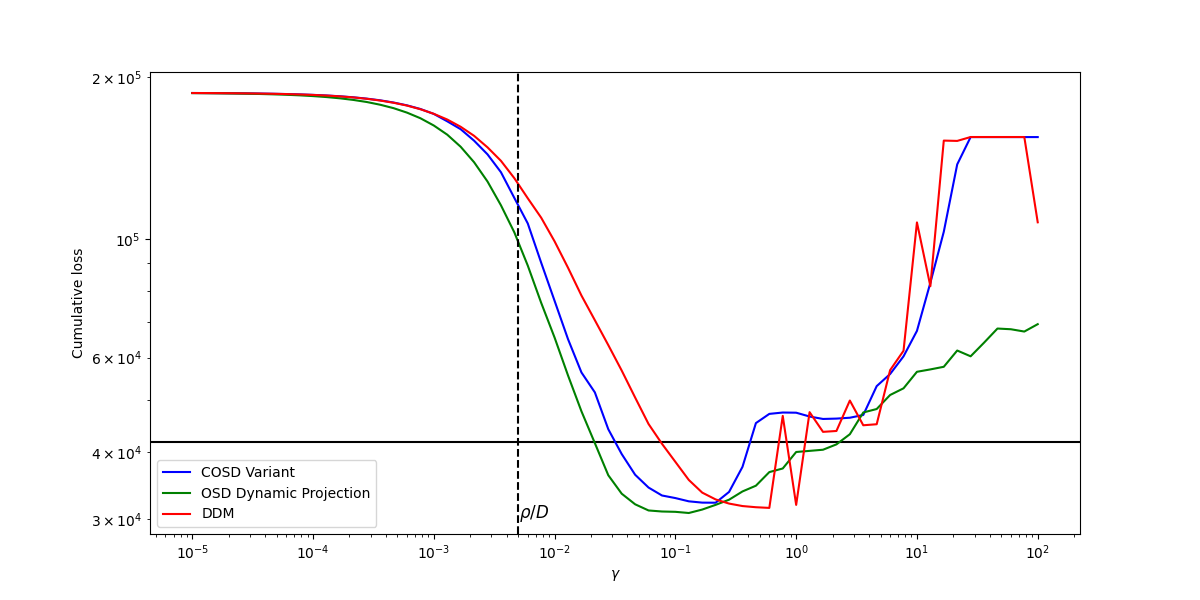

In [ ]:
plt.figure(figsize=(12,6))
plt.axhline(cum_losses[0,0,-1],color="black")


plt.loglog(list_gamma,cum_losses[0,1:len(list_gamma)+1,-1], color="blue", label="COSD Variant")
#plt.semilogx(list_gamma,cum_losses[0,len(list_gamma)+1:2*len(list_gamma)+1,-1], color="orange", marker="x",label="RCOSD Variant 2")
plt.loglog(list_gamma,cum_losses[0,1*len(list_gamma)+1:2*len(list_gamma)+1,-1], color="green", label="OSD Dynamic Projection")
plt.loglog(list_gamma,cum_losses[0,2*len(list_gamma)+1:3*len(list_gamma)+1,-1], color="red", label="DDM")

plt.axvline(gamma,linestyle="--",color="black")
plt.xlabel(r"$\gamma$")
plt.ylabel("Cumulative loss")
plt.legend()
plt.text(gamma+0.0001, plt.gca().get_ylim()[0]+0.01*plt.gca().get_ylim()[1], r"$\rho/D$", fontsize=12)
plt.show()

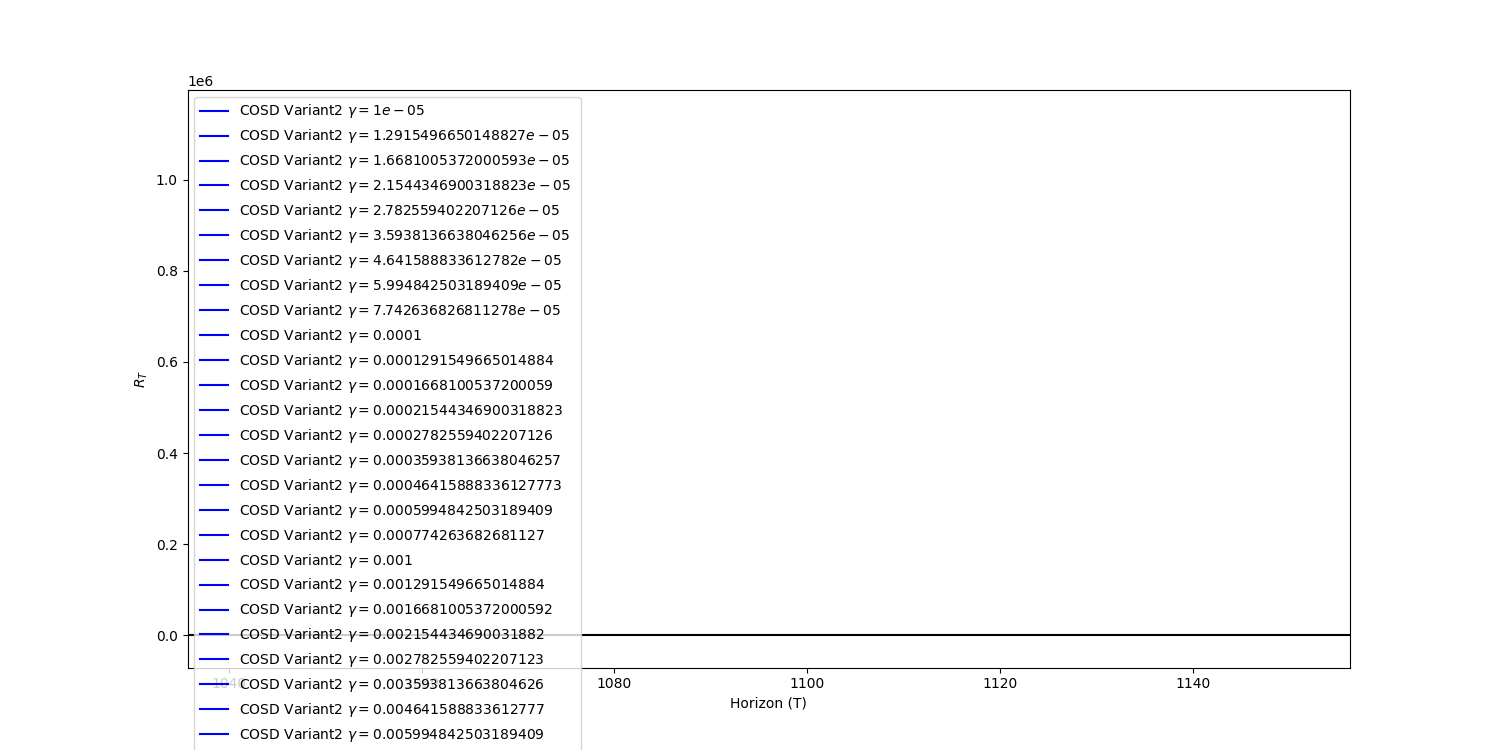

In [ ]:
plt.figure(figsize=(15,7.5))
for i in range(nb_algs) :
    y = np.mean(cum_losses[:,i+1,:]-cum_losses[:,0,:],axis=0)
    color = "blue"
    if(isinstance(algs[i], DDM_algorithm)) :
        color="red"
    if(isinstance(algs[i], OSD_Dynamic_Projection_Volume_Constrained_algorithm)) :
        color="green"
    plt.plot(horizons, y,label=algs[i],color=color)
plt.axhline(0,color="k")
plt.ylabel(r"$R_T$")
plt.xlabel("Horizon (T)")
plt.legend(loc="upper left")
plt.show()

NameError: name 'alg_index' is not defined

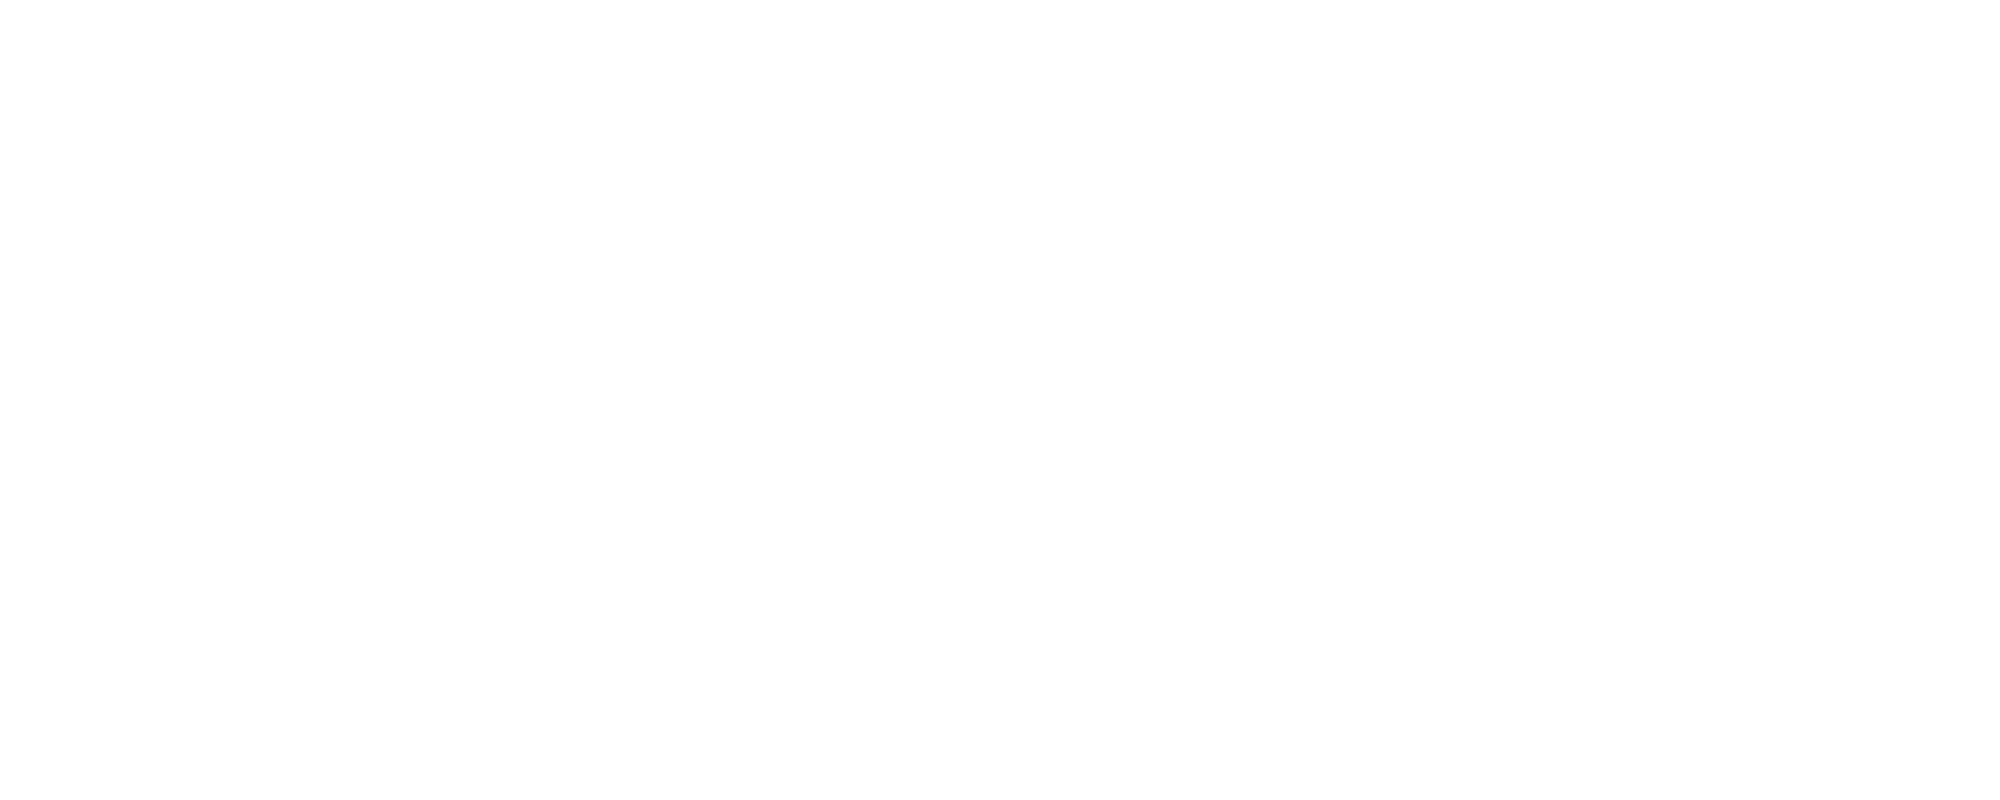

In [ ]:
plt.figure(figsize=(20,8))
for i in range(nb_algs+1) :
    y = np.mean(cum_losses[:,i,:], axis=0)/horizons
    color = "blue"
    if(isinstance(algs[i-1], DDM_algorithm)) :
        color="red"
    if(isinstance(algs[alg_index], OSD_Dynamic_Projection_Volume_Constrained_algorithm)) :
        color="green"
    plt.plot(horizons, y,label= "Benchmark" if i==0 else algs[i-1], color="black" if i==0 else color)
plt.axhline(0,color="k")
#plt.plot(horizons,np.sqrt(horizons)*D/2*np.sqrt(2/np.pi),"--",color="k",label="theoretical equivalent")
#plt.plot(horizons,np.sqrt(horizons)*D/(4*np.sqrt(2)),"x",color="k",label="theoretical lower bound")
plt.title(r"$\frac{1}{T} \sum_{t=1}^T \ell_{t}(y_t)$")
plt.xlabel("Horizon (T)")
plt.legend(loc="lower right")
plt.show()